# OC PROJET 5 - AUTOMATICALLY CATEGORIZE QUESTIONS
#### TESTS NOTEBOOK
<br></br>
### SOMMAIRE
- <a href="#C1">I. Approche Supervisée</a>
    - 1. SVC avec Tf-Idf
    - 2. Multinomial NB avec bag of words
    - 3. LogisticRegression avec TfIdf
    - 4. Word2Vec avec plusieurs modèles
    - 5. BERT
    - 6. USE
    - 7. Comparaison entre Body,Title et plus de Tags
    
- <a href="#C2">II. Approche Non Supervisée</a>
    - 1. Clustering avec Kmeans
    - 2. Prédiction avec Kmeans, 1ère approche
    - 3. Prédiction avec Kmeans, 2ème approche

- <a href="#C3">III. Conclusion et choix du modèle définitif</a>

In [1]:
# importation des librairies
import time
import os
import numpy as np
import pandas as pd
import re
import pickle
from sklearn import cluster, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import manifold, decomposition
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import transformers
from transformers import *
os.environ["TF_KERAS"]='1'

# <a name="C1">I. Approche Supervisée</a>

<font size="5">1. SVC avec Tf-Idf</font>

In [ ]:
# Séparation des données en variables prédictives (X) et variable cible (y)
X = data['body_clean']
y = data['main_tag']

# Extraction des mots clés pré-définis
mots_cles = ['c#', 'java', 'javascript', 'python', 'c++', 'android', 'ios', '.net', 'html', 'php'] 

# Création du vecteur de caractéristiques en utilisant TF-IDF
vectorizer = TfidfVectorizer(vocabulary=mots_cles)

# Transformation du texte en vecteurs
X_vecteurs = vectorizer.fit_transform(X)

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_vecteurs, y, test_size=0.2, random_state=42)

# Définition du modèle de classification (SVM)
model = SVC()

# Définition des hyperparamètres à rechercher avec GridSearchCV
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01, 0.001]}

In [5]:
# Recherche sur grille pour trouver les meilleurs paramètres
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres trouvés
print("Meilleurs paramètres :", grid_search.best_params_)

# Prédiction sur l'ensemble de test avec les meilleurs paramètres
y_pred = grid_search.predict(X_test)

# Évaluation des performances du modèle
accuracy = (y_pred == y_test).mean()
print("Précision :", accuracy)

Meilleurs paramètres : {'C': 10, 'gamma': 0.1}
Précision : 0.33592930957016626


<font size="5">2. Multinomial NB avec bag of words</font>

In [ ]:
# Création du sac de mots
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['body_clean'])

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, df['main_tag'], test_size=0.2, random_state=42)

# Définition de la grille des hyperparamètres
param_grid = {'alpha': [0.01, 0.1, 1.0]}

# Entraînement du classificateur bayésien naïf
clf = MultinomialNB()

In [52]:
# Recherche par grille pour l'optimisation des hyperparamètres
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres et meilleur score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Meilleurs hyperparamètres : ", best_params)
print("Meilleur score : {:.2f}%".format(best_score * 100))

# Prédiction sur l'ensemble de test avec les meilleurs hyperparamètres
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Calcul de l'exactitude (accuracy) du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Exactitude du modèle : {:.2f}%".format(accuracy * 100))

# Rapport de classification
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

Meilleurs hyperparamètres :  {'alpha': 1.0}
Meilleur score : 66.87%
Exactitude du modèle : 67.81%
Classification Report:
              precision    recall  f1-score   support

        .net       0.00      0.00      0.00       288
     android       0.71      0.59      0.64       872
          c#       0.58      0.78      0.67      2385
         c++       0.71      0.79      0.75      1593
        html       0.44      0.17      0.24       267
         ios       0.82      0.61      0.70       885
        java       0.77      0.64      0.70      2212
  javascript       0.63      0.74      0.68      2108
         php       0.60      0.43      0.50       744
      python       0.77      0.77      0.77      2000

    accuracy                           0.68     13354
   macro avg       0.60      0.55      0.56     13354
weighted avg       0.67      0.68      0.67     13354



In [53]:
# Enregistrement du modèle dans un fichier pickle
filename = 'multinomial_best.pickle'
pickle.dump(best_clf, open(filename, 'wb'))

<font size="5">3. LogisticRegression avec TfIdf</font>

In [ ]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df['body_clean'], 
df['main_tag'], test_size=0.2, random_state=42)

# Création d'un pipeline pour le traitement des données et la classification
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# Paramètres pour la recherche de la meilleure configuration
parameters = {
    'tfidf__max_features': [500, 1000, 2000],
    'clf__C': [1, 10, 100]
}

In [49]:
# Recherche de la meilleure configuration avec GridSearchCV
grid_search = GridSearchCV(pipeline, parameters, cv=5)
grid_search.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = grid_search.predict(X_test)

# Rapport de classification
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

# Exemple de prédiction avec une question donnée
question = "how can i create an api for android ?"
predicted_keywords = grid_search.predict([question])

print("\nExemple de prédiction :")
print(f"Question : {question}")
print(f"Mots-clés prédits : {predicted_keywords}")

C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Classification Report:
              precision    recall  f1-score   support

        .net       0.54      0.05      0.08       288
     android       0.72      0.63      0.67       872
          c#       0.64      0.77      0.70      2385
         c++       0.77      0.80      0.78      1593
        html       0.44      0.24      0.31       267
         ios       0.75      0.69      0.72       885
        java       0.77      0.73      0.75      2212
  javascript       0.71      0.74      0.72      2108
         php       0.59      0.50      0.54       744
      python       0.79      0.85      0.82      2000

    accuracy                           0.72     13354
   macro avg       0.67      0.60      0.61     13354
weighted avg       0.71      0.72      0.71     13354


Exemple de prédiction :
Question : how can i create an api for android ?
Mots-clés prédits : ['android']


J'ai décidé de sauvegarder le modèle car il possède une haute accuracy
pour tout ce qui a été essayé jusqu'à présent (0.72)

In [51]:
# Enregistrement du modèle dans un fichier pickle
filename = 'logistic_best.pickle'
pickle.dump(grid_search, open(filename, 'wb'))

In [31]:
l_cat = list(set(data_T0['main_tag']))

y_cat_num = [(1-l_cat.index(data_T0.iloc[i]['main_tag'])) for i in range(len(data_T0))]

In [ ]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(set(y_train))
    
    # Vectorisation TF-IDF
    vectorizer = TfidfVectorizer()
    X_tfidf = vectorizer.fit_transform(features)
    
    # Réduction de dimension avec T-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(X_tfidf.toarray())
    
    # Détermination des clusters à partir des données après T-SNE
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    
    ARI = np.round(metrics.adjusted_rand_score(y_train, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    
    print("ARI : ", ARI, "time : ", time2)
    return ARI, X_tsne, cls.labels_

# Visualisation du T-SNE selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_train, labels, ARI):
    l_cat = list(set(y_train))
    
    fig = plt.figure(figsize=(15, 6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=[l_cat.index(cat) for cat in y_train], cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Catégorie")
    plt.title('Représentation des mots-clés par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des mots-clés par clusters')
    
    plt.show()
    print("ARI : ", ARI)

ARI :  0.0378 time :  855.0


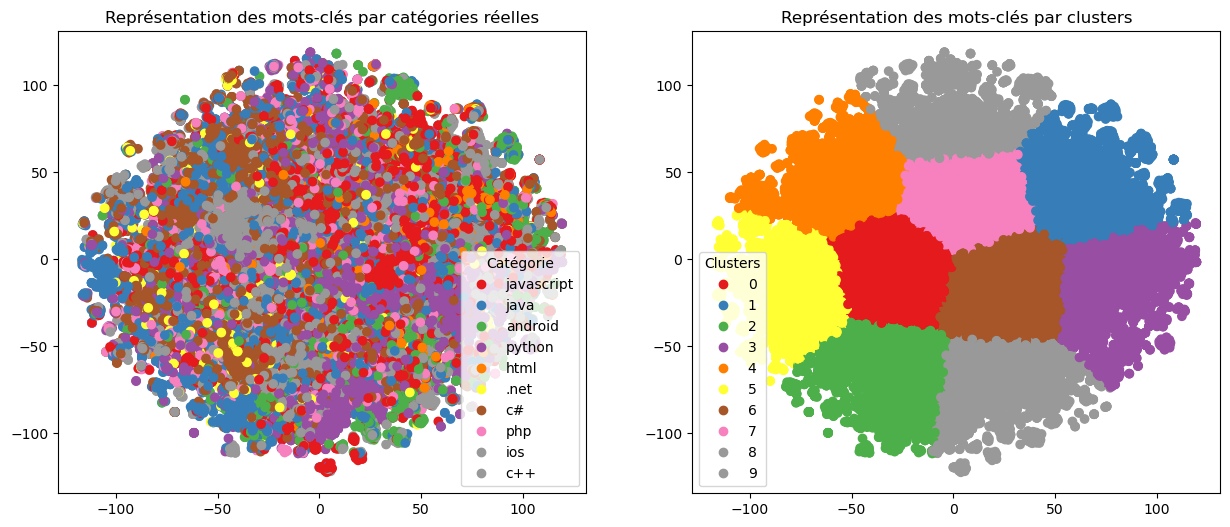

ARI :  0.0378


In [33]:
# Appel de la fonction ARI_fct pour calculer T-SNE, les clusters et l'ARI
ARI, X_tsne, labels = ARI_fct(X_train)

# Appel de la fonction TSNE_visu_fct pour visualiser les résultats
TSNE_visu_fct(X_tsne, y_train, labels, ARI)

<font size="5">4. Word2Vec avec plusieurs modèles</font>

In [4]:
# Définition des variables X et y
X = df_main_tag['body_clean']
y = df_main_tag['main_tag']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Sélection des phrases pour l'entraînement
sentences = X_train

# Création d'un modèle Word2Vec avec les phrases d'entraînement
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=12)

# Fonction pour obtenir les embeddings de mots
def get_word_embeddings(words):
    embeddings = []
    for word in words:
        if word in model.wv.key_to_index:
            embeddings.append(model.wv[word])
    if not embeddings:
        # Si aucun mot n'est présent dans le modèle Word2Vec, renvoyer un vecteur nul
        embeddings.append(np.zeros(100))
    return embeddings

# Calcul des embeddings moyens pour les données d'entraînement et de test
X_train_embeddings = [np.mean(get_word_embeddings(word), axis=0) for word in X_train]
X_test_embeddings = [np.mean(get_word_embeddings(word), axis=0) for word in X_test]

In [6]:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_embeddings, y_train)

y_pred = classifier.predict(X_test_embeddings)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.3059816647000091


In [8]:
classifier = SVC()
classifier.fit(X_train_embeddings, y_train)

y_pred = classifier.predict(X_test_embeddings)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.3149677770717981


In [10]:
classifier = RandomForestClassifier()
classifier.fit(X_train_embeddings, y_train)

y_pred = classifier.predict(X_test_embeddings)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.30203322138513206


In [12]:
classifier = GradientBoostingClassifier()
classifier.fit(X_train_embeddings, y_train)

y_pred = classifier.predict(X_test_embeddings)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.3128800943995643


In [14]:
classifier = GaussianNB()
classifier.fit(X_train_embeddings, y_train)

y_pred = classifier.predict(X_test_embeddings)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.1908868112916402


<font size="5">5. BERT</font>

In [23]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.1
2.10.1
Num GPUs Available:  0
True


In [26]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [34]:
# Définition des paramètres
max_length = 64
batch_size = 10

# Chargement du modèle pré-entraîné
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)

# Extraction des phrases du jeu de données et conversion en liste
sentences = data_T['sentence_dl'].to_list()

loading configuration file config.json from cache at C:\Users\omira/.cache\huggingface\hub\models--bert-base-uncased\snapshots\a265f773a47193eed794233aa2a0f0bb6d3eaa63\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at C:\Users\omira/.cache\huggingface\hub\models--bert-base-uncased\snapshots\a265f773a47193eed794233aa2a0f0bb6d3eaa

In [35]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
max_length, batch_size, mode='HF')

loading configuration file config.json from cache at C:\Users\omira/.cache\huggingface\hub\models--bert-base-uncased\snapshots\a265f773a47193eed794233aa2a0f0bb6d3eaa63\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\omira/.cache\huggingface\hub\models--bert-base-uncased\snapshots\a265f773a47193eed794233aa2a0f0bb6d3eaa63\vocab.t

1/1 [==============================] - 0s 451ms/step
temps traitement :  9.0


In [36]:
ARI, X_tsne, labels = ARI_fct(features_bert)

C:\Users\omira\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


ARI :  0.0419 time :  8.0


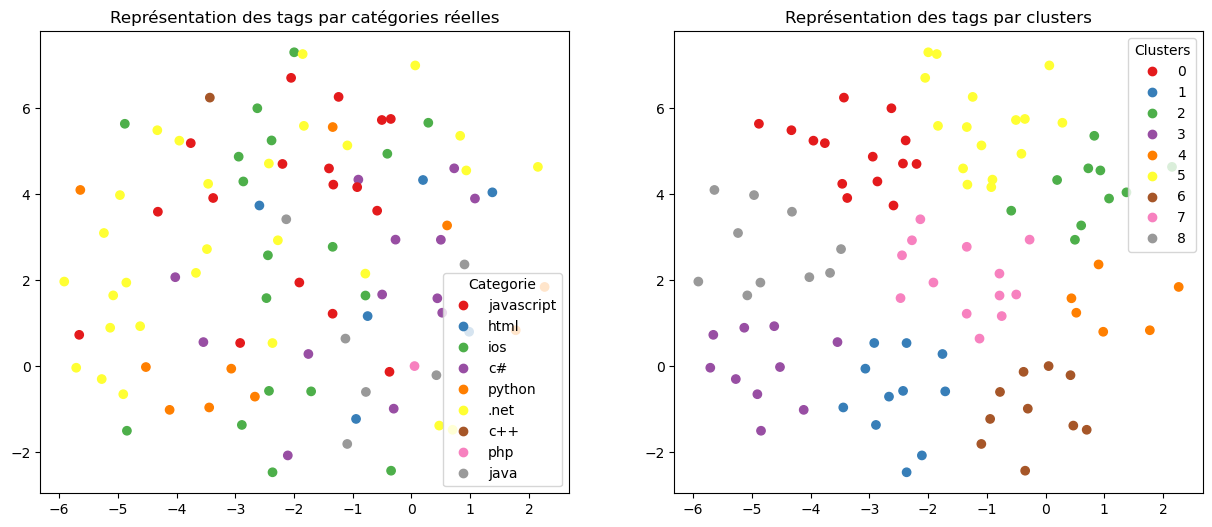

ARI :  0.0419


In [37]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

<font size="5">6. USE</font>

In [27]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [28]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [29]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()

In [30]:
features_USE = feature_USE_fct(sentences, batch_size)

In [49]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.0647 time :  433.0


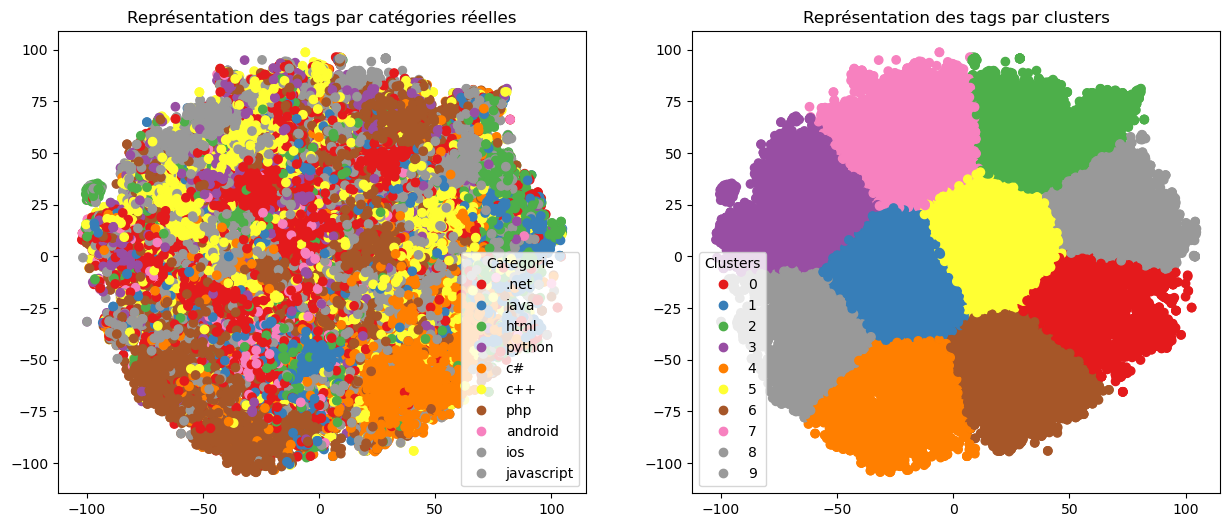

ARI :  0.0647


In [50]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

<font size="5">7. Comparaison entre Body,Title et plus de Tags</font>

In [ ]:
# Création du sac de mots
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['title_preprocess'])

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, df['main_tag'], test_size=0.2, random_state=42)

# Définition de la grille des hyperparamètres
param_grid = {'alpha': [0.01, 0.1, 1.0]}

# Entraînement du classificateur bayésien naïf
clf = MultinomialNB()

In [40]:
# Recherche par grille pour l'optimisation des hyperparamètres
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres et meilleur score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Meilleurs hyperparamètres : ", best_params)
print("Meilleur score : {:.2f}%".format(best_score * 100))

# Prédiction sur l'ensemble de test avec les meilleurs hyperparamètres
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Calcul de l'exactitude (accuracy) du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Exactitude du modèle : {:.2f}%".format(accuracy * 100))

# Rapport de classification
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

Meilleurs hyperparamètres :  {'alpha': 0.1}
Meilleur score : 54.13%
Exactitude du modèle : 54.60%
Classification Report:
                     precision    recall  f1-score   support

               .net       0.19      0.09      0.13       245
          algorithm       0.34      0.36      0.35       140
amazon-web-services       0.44      0.49      0.47        97
            android       0.60      0.67      0.63       876
            angular       0.53      0.38      0.44       178
             arrays       0.18      0.04      0.06        53
            asp.net       0.30      0.11      0.16       152
       asp.net-core       0.00      0.00      0.00        32
                  c       0.34      0.32      0.33       471
                 c#       0.57      0.64      0.60      2407
                c++       0.57      0.66      0.61      1560
                css       0.26      0.09      0.13       113
           database       0.00      0.00      0.00        62
             django     

C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Création du sac de mots
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['body_clean'])

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, df['main_tag'], test_size=0.2, random_state=42)

# Définition de la grille des hyperparamètres
param_grid = {'alpha': [0.01, 0.1, 1.0]}

# Entraînement du classificateur bayésien naïf
clf = MultinomialNB()

In [41]:
# Recherche par grille pour l'optimisation des hyperparamètres
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres et meilleur score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Meilleurs hyperparamètres : ", best_params)
print("Meilleur score : {:.2f}%".format(best_score * 100))

# Prédiction sur l'ensemble de test avec les meilleurs hyperparamètres
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Calcul de l'exactitude (accuracy) du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Exactitude du modèle : {:.2f}%".format(accuracy * 100))

# Rapport de classification
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

Meilleurs hyperparamètres :  {'alpha': 1.0}
Meilleur score : 50.92%
Exactitude du modèle : 50.54%
Classification Report:
                     precision    recall  f1-score   support

               .net       0.16      0.14      0.15       245
          algorithm       0.41      0.69      0.51       140
amazon-web-services       0.63      0.43      0.51        97
            android       0.59      0.61      0.60       876
            angular       0.51      0.39      0.45       178
             arrays       0.00      0.00      0.00        53
            asp.net       0.26      0.07      0.11       152
       asp.net-core       0.00      0.00      0.00        32
                  c       0.39      0.40      0.39       471
                 c#       0.55      0.62      0.58      2407
                c++       0.53      0.67      0.59      1560
                css       0.14      0.01      0.02       113
           database       0.00      0.00      0.00        62
             django     

C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# <a name="C2">II. Approche Non Supervisée</a>

<font size="5">1. Clustering avec Kmeans</font>

In [45]:
inertia = []
K_range = range(1, 10)
for k in K_range:
    model = KMeans(n_clusters = k).fit(X)
    inertia.append(model.inertia_)

C:\Users\Oliver\AppData\Local\Temp\ipykernel_4460\804946866.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K_range, inertia, 'bx-', color = 'springgreen')


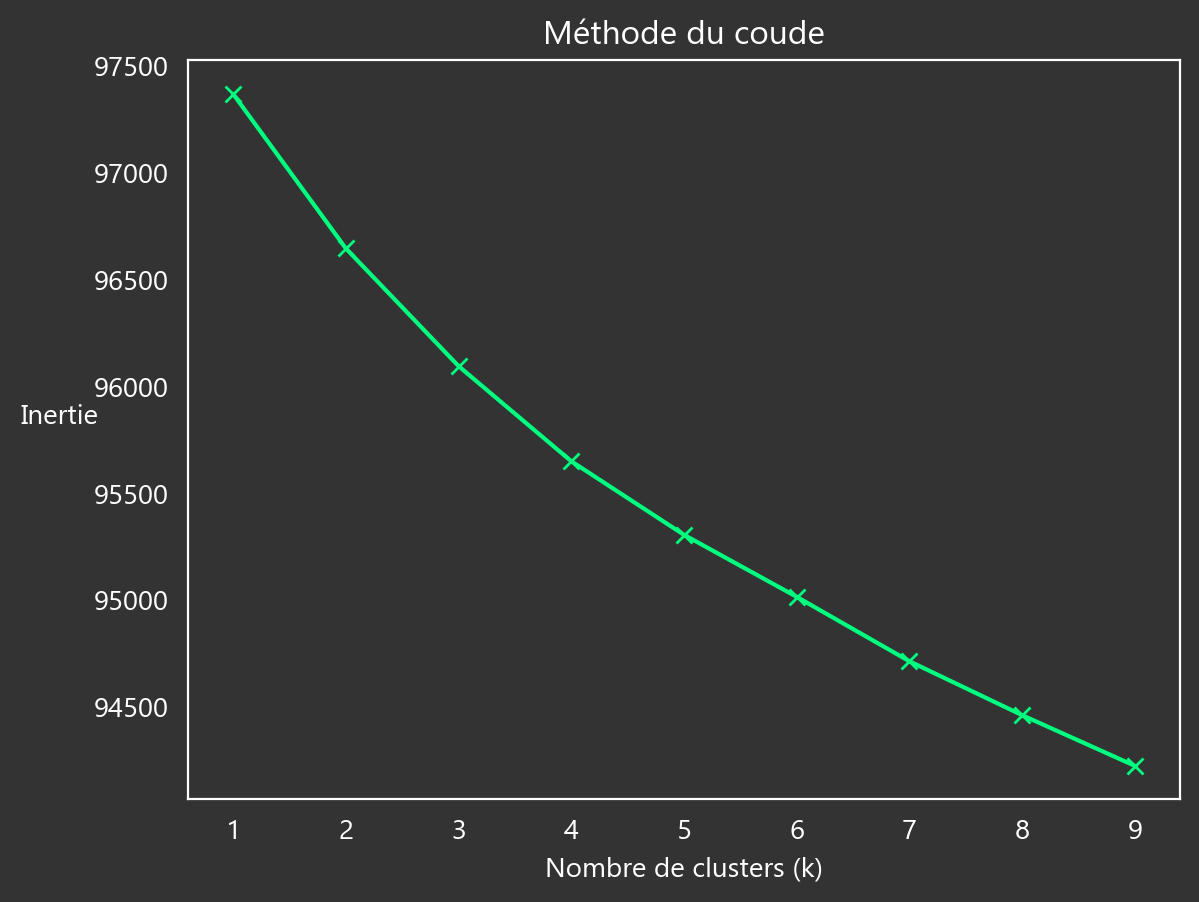

In [47]:
plt.rcParams['font.family'] = 'Ebrima'
plt.plot(K_range, inertia, 'bx-', color = 'springgreen')
plt.xlabel('Nombre de clusters (k)', color = 'white')
plt.gca().yaxis.set_label_coords( - 0.13, 0.5)
plt.ylabel('Inertie', rotation = 360, color = 'white')
plt.title('Méthode du coude')
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.grid(False)
plt.show()

In [44]:
# Extraction des fonctionnalités avec TF-IDF
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(df["Body"])

# Application de l'algorithme de clustering (K-means)
num_clusters = 4  # Nombre de clusters souhaité
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# Affichage des mots clés pour chaque cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster", i)
    for ind in order_centroids[i, :10]:  # Afficher les 10 mots clés les plus représentatifs
        print(terms[ind])
    print()

Cluster 0
like
code
use
function
want
data
way
return
value
work

Cluster 1
import
error
file
return
component
export
react
module
class
code

Cluster 2
file
error
project
run
build
line
version
install
command
code

Cluster 3
public
class
new
private
void
string
return
static
method
null



C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Cluster 0:
Ce cluster est axé sur les mots liés à la manipulation du code et des fonctions. Les mots "like", "code", "use", "function", "want", "data", "way", "return", "value" et "work" suggèrent que les utilisateurs posent des questions sur l'utilisation de fonctions, la manipulation des données et la recherche de solutions de travail.

Cluster 1:
Ce cluster est lié à l'importation, aux erreurs et à la manipulation de fichiers dans le contexte du développement de logiciels. Les mots "import", "error", "file", "return", "component", "export", "react", "module" et "class" indiquent que les utilisateurs posent des questions sur l'importation de modules, la gestion des erreurs et la manipulation des fichiers dans le cadre du développement avec React.

Cluster 2:
Ce cluster est centré sur les mots liés aux erreurs, aux projets et à l'exécution de commandes. Les mots "file", "error", "project", "run", "build", "line", "version", "install" et "command" suggèrent que les utilisateurs posent des questions sur la gestion des erreurs, l'exécution de projets, la construction de programmes et l'installation de logiciels.

Cluster 3:
Ce cluster est associé à des mots clés liés à la programmation orientée objet. Les mots "public", "class", "new", "private", "void", "string", "return", "static", "method" et "null" indiquent que les utilisateurs posent des questions sur les concepts de classes, d'objets, de méthodes et de variables dans la programmation orientée objet.

In [54]:
kmeans_labels = kmeans.labels_
# Évaluer les performances du modèle K-means
silhouette_score = metrics.silhouette_score(X.toarray(), kmeans_labels)
calinski_harabasz_score = metrics.calinski_harabasz_score(X.toarray(), kmeans_labels)
davies_bouldin_score = metrics.davies_bouldin_score(X.toarray(), kmeans_labels)

In [55]:
print("Scores K-means :")
print("Silhouette score :", silhouette_score)
print("Calinski-Harabasz score :", calinski_harabasz_score)
print("Davies-Bouldin score :", davies_bouldin_score)

Scores K-means :
Silhouette score : 0.0035867528631406825
Calinski-Harabasz score : 599.4805359501959
Davies-Bouldin score : 7.799644634682886


<font size="5">2. Prédictions avec Kmeans, 1ère approche</font>

In [ ]:
# Liste de questions
questions = df['Body']

# Initialisation du vectoriseur bag-of-words
vectorizer = CountVectorizer()

# Construction de la matrice de termes-document
X = vectorizer.fit_transform(questions)

In [61]:
# Application de l'algorithme K-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

# Récupération des mots les plus fréquents dans chaque cluster
n_words = 10
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(4):
    print(f"Cluster {i+1} mots clés :")
    for j in range(n_words):
        print(f"- {terms[order_centroids[i, j]]}")
    print()

# Suggestions de tags basées sur les mots clés fréquents dans chaque cluster
suggested_tags = []
for i in range(4):
    tags = [terms[order_centroids[i, j]] for j in range(n_words)]
    suggested_tags.append(tags)

print("Suggestions de tags :")
for i, tags in enumerate(suggested_tags):
    print(f"Cluster {i+1} : {tags}")

Cluster 1 mots clés :
- public
- class
- new
- return
- private
- string
- void
- get
- null
- set

Cluster 2 mots clés :
- builder
- step
- version
- python
- file
- line
- requirement
- warning
- parse
- starting

Cluster 3 mots clés :
- code
- like
- use
- get
- error
- file
- would
- return
- new
- work

Cluster 4 mots clés :
- file
- error
- import
- line
- return
- code
- function
- get
- data
- run

Suggestions de tags :
Cluster 1 : ['public', 'class', 'new', 'return', 'private', 'string', 'void', 'get', 'null', 'set']
Cluster 2 : ['builder', 'step', 'version', 'python', 'file', 'line', 'requirement', 'warning', 'parse', 'starting']
Cluster 3 : ['code', 'like', 'use', 'get', 'error', 'file', 'would', 'return', 'new', 'work']
Cluster 4 : ['file', 'error', 'import', 'line', 'return', 'code', 'function', 'get', 'data', 'run']


<font size="5">3. Prédictions avec Kmeans, 2ème approche</font>

In [ ]:
# Vectorisation des données textuelles
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['body_clean'])

# Définir les paramètres pour la recherche de grille
param_grid = {'n_clusters': [4, 5]}  # Nombre de clusters à essayer

# Initialiser le modèle de clustering
kmeans = KMeans(random_state=42)

In [6]:
# Effectuer la recherche de grille avec cross-validation
grid_search = GridSearchCV(kmeans, param_grid=param_grid, cv=5)
grid_search.fit(X)

# Obtenir le meilleur modèle
best_kmeans = grid_search.best_estimator_

# Obtenir le meilleur nombre de clusters
best_n_clusters = grid_search.best_params_['n_clusters']

# Effectuer le clustering avec le meilleur modèle
predicted_labels = best_kmeans.fit_predict(X)

# Calculer le score de silhouette pour les clusters prédits
silhouette_avg = silhouette_score(X, predicted_labels)

# Afficher les résultats
print("Meilleur nombre de clusters trouvé :", best_n_clusters)
print("Score de silhouette :", silhouette_avg)

# Prédiction avec le modèle optimisé
question_index = 0  # Indice de la question à afficher
predicted_cluster = predicted_labels[question_index]
predicted_keywords = df.iloc[predicted_labels == predicted_cluster]['body_clean'].values

print("Question originale :", df.iloc[question_index]['body_clean'])
print("Mots-clés prédits :", predicted_keywords)

C:\Users\omira\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Meilleur nombre de clusters trouvé : 5
Score de silhouette : 0.0033415598668624725
Question originale : want assign decimal variable double variable decimal trans 5000 trans build app give following error cannot implicitly convert type decimal double
Mots-clés prédits : ['want assign decimal variable double variable decimal trans 5000 trans build app give following error cannot implicitly convert type decimal double'
 'given specific value display relative time like 2 hour ago 3 day ago month ago'
 'standard way web server able determine user timezone within web page perhaps header part string'
 ...
 'bootstrap 4 layout similar many nav item want hidden added nav job problem also hide menu hide extra menu item still allow show visible item disabled else starter document way quickly start new project get text mostly container gt'
 'want check vector integer duplicate return true try something like 123345 work since cannot assigned value proceed towards write loop perform action'
 'issue

# <a name="C3">III. Conclusion et choix du modèle définitif</a>

L'approche supervisée et bien plus exploitable que l'approche supervisée qui peux me retourner des clusters pertinent et des mots-clés associés à chaque clusters, cependant pour faire de la simple prédiction ça ne marche pas du tout.

J'ai donc décider de garder le modèle de régression logistique qui a obtenu une accuracy générale de 0.72, ce qui est le plus haut de tout ce que j'ai pu essayer auparavant.

Ce n'est pas un score parfait mais sur un dataframe de cette taille c'est largement acceptable, avec plus de données et une meilleure machine en termes de puissance, ce modèle pourrait atteindre de meilleurs scores

Ce sera donc 'logistic_best.pickle' qui sera utiliser dans l'application